In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import STATUS_OK, hp, fmin, tpe, Trials, space_eval

from time import time
import operator

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import itertools
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

### Start training

In [13]:
# Import data
def load_data():
    full_data = pd.read_csv("X.csv")
    train_y = pd.read_csv("ytr.csv")
    # Rename columns to something more interpretable
    columns = (["reflectance_" + str(i) for i in range(7)]
               + ["solar_" + str(i) for i in range(5)] + ["id"])
    full_data.columns = columns
    # Add y to the data frame
    split = 98000
    y_id_dict = train_y.set_index("Id")["y"].to_dict()
    full_data.loc[:(split-1), "y"] = full_data.loc[:(split-1), "id"].replace(y_id_dict)

    train, test = full_data[:split], full_data[split:]
    return (train, test)

#columns = (["id"] + ["reflectance_" + str(i) for i in range(7)]
#           + ["solar_" + str(i) for i in range(5)] + ["y"])
#full_data = pd.read_csv("MODIS.csv", header=None, names=columns)
#split = 98000
#train, test = full_data[:split].copy(), full_data[split:].copy()
train, test = load_data()

# Parameters
outliers_threshold = 0.01
n_threads = -1
random_seed = 22

In [18]:
train.head()

,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,id,y
0,1.580642,2.482233,5.887092,4.732722,4.408482,3.830171,4.388508,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
1,2.338455,3.627796,4.723716,3.324726,2.743442,4.727652,2.810193,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
2,2.224569,3.522241,6.188831,4.389783,4.177616,4.945918,4.122848,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
3,1.717218,2.712012,5.024211,3.944907,3.393424,3.931973,3.489578,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
4,2.378857,3.644976,4.515292,3.223825,2.739952,4.599662,2.781574,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082


### Preprocessing

In [15]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]

### Neural net

In [22]:
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_orig]

regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                          hidden_units=[9, 9],
                                          model_dir="./temp_log")

def input_fn(data_set):
    feature_cols = {k: tf.constant(data_set[k].values) for k in cols_orig}
    labels = tf.constant(data_set["y"].values)
    
    return feature_cols, labels

regressor.fit(input_fn=lambda: input_fn(train), steps=1000)

ev = regressor.evaluate(input_fn=lambda: input_fn(train), steps=1)
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x113dee050>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


### Step AIC for linear regression

In [41]:
#import itertools
#import statsmodels.api as sm

#AICs = {}
#for k in range(10, len(cols_orig)+1):
 #   for variables in itertools.combinations(cols_orig, k):
  #      predictors = train.loc[:, list(variables)]
   #     predictors.loc[:, "Intercept"] = 1
    #    res = sm.OLS(train["y"], predictors).fit()
     #   AICs[variables] = 2*(k+1) - 2*res.llf
#pd.Series(AICs).idxmin()

### Cross-validation

In [10]:
## Gradient boosting
cols_xgb = cols_orig
cols_lr0 = cols_orig
cols_lr1 = cols_orig

n_trees = 20
models_weights = {"lr0": 1.0}
models_weights_agg = {"lr0": 0.7, "lr1": 0.3, "xgb": 0.}
models_cols = {"lr0": cols_lr0, "lr1": cols_lr1, "xgb": cols_xgb}

# Scoring function in the hyperopt hyperparameters tuning.
def scoring_function(parameters):
    print("Training the model with parameters: ")
    print(parameters)
    early_stopping_rounds = 5
    average_RMSE = 0.0
    n_splits = 5

    kf = KFold(n_splits=n_splits)
    for train_index, validation_index in kf.split(train):
        train_fold, validation_fold = train.loc[train_index], train.loc[validation_index] 

        model_lr0 = LinearRegression()
        model_lr0.fit(train_fold[cols_lr0], train_fold["y"])

        models = {"lr0": model_lr0}

        train_pred = train_fold[["id"]].assign(y_hat=0)
        for i, m in models.items():
            train_pred["y_hat"] += models_weights[i] * m.predict(train_fold[models_cols[i]])

        # Use median value by id
        y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

        RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med).values, train_fold["y"]))
        
        # Prune outliers
        RMSE_decreasing = True
        count = 0
        while (RMSE_decreasing):
            count +=1
            if ((count % 5) == 0):
                print(count)
            train_pred["y_med"] = train_pred["id"].replace(y_hat_med)

            # Distance from the median for each bag
            train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
            # Rank of each instance by bag
            train_pred["rank"] = train_pred.groupby("id")["score"].rank()
            bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
            train_pred["bag_size"] = train_pred["id"].replace(bag_size_dict)
            train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

            # Remove outliers
            outliers_index = train_pred["rank"] > (1 - outliers_threshold)
            train_fold = train_fold.loc[~outliers_index, :].reset_index(drop=True)

            model_lr0 = LinearRegression()
            model_lr0.fit(train_fold[cols_lr0], train_fold["y"])

            models = {"lr0": model_lr0}

            # Compute new RMSE
            train_pred = train_fold[["id"]].assign(y_hat=0)
            
            for i, m in models.items():
                train_pred["y_hat"] += models_weights[i] * m.predict(train_fold[models_cols[i]])

            # Use median value by id
            y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

            new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med), train_fold["y"]))
            if ((count % 5) == 0):
                print(new_RMSE)

            if (new_RMSE < RMSE):
                RMSE = new_RMSE
            else:
                RMSE_decreasing = False
        
        # Aggregated prediction
        agg_train_fold = train_fold.groupby("id").median().reset_index()
        agg_validation = validation_fold.groupby("id").median().reset_index()
        
        # Linear Model
        model_lr1 = LinearRegression()
        model_lr1.fit(agg_train_fold[cols_lr1], agg_train_fold["y"])
        
        # Gradient boosting
        D_train = xgb.DMatrix(agg_train_fold[cols_xgb], label=agg_train_fold["y"])
        D_validation = xgb.DMatrix(agg_validation[cols_xgb], label=agg_validation["y"])
        
        # Two eval metrics to print. Validation-rmse will be used for early stopping.
        watchlist = [(D_train, "Training"), (D_validation, "Validation")]
        model_xgb = xgb.train(parameters, D_train, n_trees, watchlist, 
                              early_stopping_rounds=early_stopping_rounds,
                              verbose_eval=5)
        
        models_agg = {"lr1": model_lr1, "xgb": model_xgb}
        
        # Compute RMSE on validation set
        validation_pred = validation_fold[["id"]].assign(y_hat=0).reset_index(drop=True)
        for i, m in models.items():
            validation_pred["y_hat"] += models_weights_agg[i] * m.predict(validation_fold[models_cols[i]])
        
        agg_validation["agg_y_hat"] = 0.0
        # Aggregated prediction
        for i, m in models_agg.items():
            if (i == "xgb"):
                agg_validation["agg_y_hat"] += models_weights_agg[i] * m.predict(D_validation,
                                                                          ntree_limit=m.best_iteration)
            else:
                agg_validation["agg_y_hat"] += models_weights_agg[i] * m.predict(agg_validation[models_cols[i]])
                
        # Add aggregated prediction
        agg_dict = dict(zip(agg_validation["id"], agg_validation["agg_y_hat"]))
        validation_pred["y_hat"] += validation_pred["id"].replace(agg_dict)
        
        # Use median value by id
        y_hat_med = validation_pred.groupby("id").median()["y_hat"].to_dict()
        
        RMSE = np.sqrt(mean_squared_error(validation_pred["id"].replace(y_hat_med).values, validation_fold["y"]))
        average_RMSE += RMSE
        print("Current validation RMSE: {0}".format(RMSE))

    average_RMSE /= n_splits

    print("Cross-validation score: {0}\n".format(average_RMSE))
    
    return {"loss": average_RMSE, "status": STATUS_OK}

In [11]:
t0 = time()

# Grid to pick parameters from.
parameters_grid = {"eta"              : hp.quniform("eta", 0.1, 0.3, 0.1),
                   "max_depth"        : hp.choice("max_depth", np.arange(4, 5, dtype=int)),
                   #"min_child_weight": hp.quniform("min_child_weight", 10, 15, 1),
                   #"gamma"           : hp.quniform("gamma", 0, 1, 0.2),
                   "subsample"        : hp.quniform("subsample", 0.4, 0.9, 0.1),
                   "lambda"           : hp.quniform("lambda", 0.2, 1.0, 0.2),
                   "objective"        : "reg:linear",
                   #"tree_method"      : "hist",
                   #"grow_policy"      : "depthwise",
                   "eval_metric"      : "rmse",
                   "seed"             : random_seed,
                   "nthread"          : n_threads,
                   "silent"           : 0
                  }
# Record the information about the cross-validation.
trials = Trials()

best = fmin(scoring_function, parameters_grid, algo=tpe.suggest, max_evals=10, 
            trials=trials) 

computing_time = time() - t0

Training the model with parameters: 
{'silent': 0, 'eval_metric': 'rmse', 'nthread': -1, 'subsample': 0.4, 'eta': 0.1, 'objective': 'reg:linear', 'seed': 22, 'max_depth': 4, 'lambda': 0.8}


//anaconda/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


5
0.803714138185
10
0.784656146371
15
0.771191639978
20
0.762613877424
25
0.755973243585
30
0.752141087366
35
0.750151486347
40
0.748836790039
[0]	Training-rmse:3.75116	Validation-rmse:3.74903
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 5 rounds.
[5]	Training-rmse:2.34093	Validation-rmse:2.36671
[10]	Training-rmse:1.55921	Validation-rmse:1.60024
[15]	Training-rmse:1.11951	Validation-rmse:1.199
[19]	Training-rmse:0.931642	Validation-rmse:1.02234
Current validation RMSE: 0.857186501785
5
0.799303166689
10
0.784706698866
15
0.774695160638
20
0.768453442706
25
0.765862010824
30
0.764553652894
35
0.763025901829
[0]	Training-rmse:3.72842	Validation-rmse:3.87536
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 5 rounds.
[5]	Training-rmse:2.33298	Validation-rmse:2.45054
[10]	Training-rmse:1.55496	Valid

KeyboardInterrupt: 

In [ ]:
0.818739649008
0.770475036604
0.771639976693
0.718388782706
0.817479974058
Cross-validation score: 0.779344683814

In [43]:
min(trials.losses())

0.7793446838139222

In [45]:
# Save the best parameters as a csv.
best_parameters = pd.DataFrame({key: [value] for (key, value) in 
                                zip(space_eval(parameters_grid, best).keys(),
                                    space_eval(parameters_grid, best).values())})
# Add the corresponding score.
best_parameters["score"] = min(trials.losses())
best_parameters.to_csv("best_parameters_2.csv", encoding="utf-8", index=False)

best_parameters

,eta,eval_metric,lambda,max_depth,nthread,objective,seed,silent,subsample,score
0,0.4,rmse,0.4,4,-1,reg:linear,22,0,0.9,0.779345


### Training models

In [4]:
cols_xgb = cols_orig
cols_lr0 = cols_orig
cols_lr1 = cols_orig

n_trees = 20
models_weights = {"lr0": 1.0}
models_weights_agg = {"lr0": 0.6, "lr1": 0.2, "xgb": 0.2}
models_cols = {"lr0": cols_lr0, "lr1": cols_lr1, "xgb": cols_xgb}

best_parameters = pd.read_csv("best_parameters_2.csv", encoding="utf-8")
parameters = dict(zip(best_parameters.columns[:-1], best_parameters.iloc[0].values[:-1]))

print("Training the model with parameters: ")
print(parameters)

model_lr0 = LinearRegression()
model_lr0.fit(train[cols_lr0], train["y"])

models = {"lr0": model_lr0}

train_pred = train[["id"]].assign(y_hat=0)
for i, m in models.items():
    train_pred["y_hat"] += models_weights[i] * m.predict(train[models_cols[i]])

# Use median value by id
y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med).values, train["y"]))
        
# Prune outliers
RMSE_decreasing = True
count = 0
while (RMSE_decreasing):
    count +=1
    if ((count % 5) == 0):
        print(count)
    train_pred["y_med"] = train_pred["id"].replace(y_hat_med)

    # Distance from the median for each bag
    train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
    # Rank of each instance by bag
    train_pred["rank"] = train_pred.groupby("id")["score"].rank()
    bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
    train_pred["bag_size"] = train_pred["id"].replace(bag_size_dict)
    train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

    # Remove outliers
    outliers_index = train_pred["rank"] > (1 - outliers_threshold)
    train = train.loc[~outliers_index, :].reset_index(drop=True)

    model_lr0 = LinearRegression()
    model_lr0.fit(train[cols_lr0], train["y"])

    models = {"lr0": model_lr0}

    # Compute new RMSE
    train_pred = train[["id"]].assign(y_hat=0)
            
    for i, m in models.items():
        train_pred["y_hat"] += models_weights[i] * m.predict(train[models_cols[i]])

    # Use median value by id
    y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

    new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med), train["y"]))
    if ((count % 5) == 0):
        print(new_RMSE)

    if (new_RMSE < RMSE):
        RMSE = new_RMSE
    else:
        RMSE_decreasing = False
        
# Aggregated prediction
agg_train = train.groupby("id").median().reset_index()
agg_test = test.groupby("id").median().reset_index()
        
# Linear Model
model_lr1 = LinearRegression()
model_lr1.fit(agg_train[cols_lr1], agg_train["y"])
        
# Gradient boosting
D_train = xgb.DMatrix(agg_train[cols_xgb], label=agg_train["y"])
D_test = xgb.DMatrix(agg_test[cols_xgb])

model_xgb = xgb.train(parameters, D_train, n_trees)
        
models_agg = {"lr1": model_lr1, "xgb": model_xgb}
        
# Compute RMSE on validation set
test_pred = test[["id"]].assign(y_hat=0).reset_index(drop=True)
for i, m in models.items():
    test_pred["y_hat"] += models_weights_agg[i] * m.predict(test[models_cols[i]])
        
agg_test["agg_y_hat"] = 0.0
# Aggregated prediction
for i, m in models_agg.items():
    if (i == "xgb"):
        agg_test["agg_y_hat"] += models_weights_agg[i] * m.predict(D_test)
    else:
        agg_test["agg_y_hat"] += models_weights_agg[i] * m.predict(agg_test[models_cols[i]])
                
# Add aggregated prediction
agg_dict = dict(zip(agg_test["id"], agg_test["agg_y_hat"]))
test_pred["y_hat"] += test_pred["id"].replace(agg_dict)
        
# Use median value by id
y_hat_med = test_pred.groupby("id").median()["y_hat"]#.to_dict()
        
#RMSE = np.sqrt(mean_squared_error(test_pred["id"].replace(y_hat_med).values, test["y"]))

#print("Validation RMSE: {0}\n".format(RMSE))

Training the model with parameters: 
{u'silent': 0, u'eval_metric': u'rmse', u'nthread': -1, u'subsample': 0.90000000000000002, u'eta': 0.40000000000000002, u'objective': u'reg:linear', u'seed': 22, u'max_depth': 4, u'lambda': 0.40000000000000002}


//anaconda/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


5
0.797593117783
10
0.783288300348
15
0.774532847503
20
0.768223861487
25
0.764337756155


### Features importance

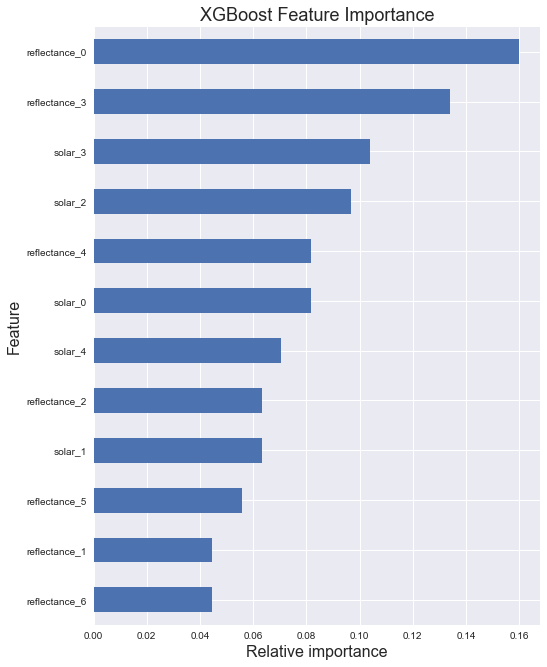

In [12]:
# get_score() gives features importance defined as: the number of time the feature
# is used to split the data across all trees.
features_importance = model_xgb.get_score()
features_importance = sorted(features_importance.items(), key=operator.itemgetter(1))

df_importance = pd.DataFrame(features_importance, columns=["Feature", "Score"])
# Divide by the sum of scores to have relative importance of each feature.
df_importance["Score"] = df_importance["Score"] / df_importance["Score"].sum()

# Plot the importance of each feature in decreasing order.
df_importance.plot(kind="barh", x="Feature", y="Score", legend=False, figsize=(8, 11))
plt.title("XGBoost Feature Importance", size=18)
plt.xlabel("Relative importance", size=16)
plt.ylabel("Feature", size=16)
plt.show()

### Predicting

In [13]:
kaggle_pred = pd.DataFrame({"Id": y_hat_med.index, "y": y_hat_med.values})
kaggle_pred.to_csv("Prediction_2.csv", encoding="utf-8", index=False)

### Benchmark:
Submit 1 (ensemble of xgboost + 2 ridge with instances model)
eta	eval_metric	gamma	lambda	max_depth	min_child_weight	nthread	objective	seed	silent	subsample	score
0.91834 Public LB 300 trees 0.09	rmse	0.2	0.8	4	4.0	-1	reg:linear	22	0	0.7	0.883339 (cross-val)
    
Submit 2

Pruning with linear regression
then add contributions of aggregated xgboost + linear model
0.78181 Public LB  0.779345 CV